# Weather Conditions in World War Two (Time Series Prediction)

Hi! Mario here! In this project I'll use a dataset from Kaggle (https://www.kaggle.com/datasets/smid80/weatherww2/data), which contains information on weather conditions recorded on each day at various weather stations around the world, for the 1940-1945 period. This information includes precipitation, snowfall, temperatures, wind speed and whether the day included thunder storms or other poor weather conditions. The idea is to predict the maximum temperature for each day, for which I'll use time series models.

The data set consists of 2 CSV files, one containing the weather summary, and the other containing the weather station locations. Let's first import some packages and load the datasets.

In [130]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate, StratifiedKFold, GridSearchCV, cross_val_score
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import TimeSeriesSplit

import warnings

warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)

In [131]:
df1 = pd.read_csv('Summary of Weather.csv')
df2 = pd.read_csv('Weather Station Locations.csv')

In [132]:
print(F'Df1 has a {df1.shape} shape')
df1.head()

Df1 has a (119040, 31) shape


,STA,Date,Precip,WindGustSpd,MaxTemp,MinTemp,MeanTemp,Snowfall,PoorWeather,YR,MO,DA,PRCP,DR,SPD,MAX,MIN,MEA,SNF,SND,FT,FB,FTI,ITH,PGT,TSHDSBRSGF,SD3,RHX,RHN,RVG,WTE
0,10001,1942-7-1,1.016,NaN,25.555556,22.222222,23.888889,0.0,NaN,42,7,1,0.04,NaN,NaN,78.0,72.0,75.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10001,1942-7-2,0,NaN,28.888889,21.666667,25.555556,0.0,NaN,42,7,2,0,NaN,NaN,84.0,71.0,78.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10001,1942-7-3,2.54,NaN,26.111111,22.222222,24.444444,0.0,NaN,42,7,3,0.1,NaN,NaN,79.0,72.0,76.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10001,1942-7-4,2.54,NaN,26.666667,22.222222,24.444444,0.0,NaN,42,7,4,0.1,NaN,NaN,80.0,72.0,76.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10001,1942-7-5,0,NaN,26.666667,21.666667,24.444444,0.0,NaN,42,7,5,0,NaN,NaN,80.0,71.0,76.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [133]:
print(F'Df2 has a {df2.shape} shape')
df2.head()

Df2 has a (161, 8) shape


,WBAN,NAME,STATE/COUNTRY ID,LAT,LON,ELEV,Latitude,Longitude
0,33013,AIN EL,AL,3623N,00637E,611,36.383333,6.650000
1,33031,LA SENIA,AL,3537N,00037E,88,35.616667,0.583333
2,33023,MAISON BLANCHE,AL,3643N,00314E,23,36.716667,3.216667
3,33044,TELERGMA,AL,3607N,00621E,754,36.116667,6.416667
4,12001,TINDOUF,AL,2741N,00809W,443,27.683333,-8.083333


From what we see, in order to perform a time series analysis I'll only need the first dataframe, more specifically, the station, date and maximum temperature columns.

In [134]:
df = df1[['STA', 'Date', 'MaxTemp']]
df

,STA,Date,MaxTemp
0,10001,1942-7-1,25.555556
1,10001,1942-7-2,28.888889
2,10001,1942-7-3,26.111111
3,10001,1942-7-4,26.666667
4,10001,1942-7-5,26.666667
...,...,...,...
119035,82506,1945-12-27,28.333333
119036,82506,1945-12-28,29.444444
119037,82506,1945-12-29,28.333333
119038,82506,1945-12-30,28.333333


Let's convert the date to datetime format.

In [135]:
df['Date'] = pd.to_datetime(df['Date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119040 entries, 0 to 119039
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype         
---  ------   --------------   -----         
 0   STA      119040 non-null  int64         
 1   Date     119040 non-null  datetime64[ns]
 2   MaxTemp  119040 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 2.7 MB


In [136]:
df.describe()

,STA,Date,MaxTemp
count,119040.000000,119040,119040.000000
mean,29659.435795,1944-04-27 16:35:07.741935616,27.045111
min,10001.000000,1940-01-01 00:00:00,-33.333333
25%,11801.000000,1943-09-03 00:00:00,25.555556
50%,22508.000000,1944-06-26 00:00:00,29.444444
75%,33501.000000,1945-03-15 00:00:00,31.666667
max,82506.000000,1945-12-31 00:00:00,50.000000
std,20953.209402,NaN,8.717817


The date goes from the 1st of January of 1940 to the 31st of December of 1945. The maximum temperature ranges from -33°C to 50°C. Let's see if there are any null values.

In [137]:
df.isnull().sum()

STA        0
Date       0
MaxTemp    0
dtype: int64

We have no null values. Let's see how many stations there are.

In [138]:
print(F'There are {len(df["STA"].unique())} stations')

There are 159 stations


The idea would be to use different time series to make predictions for each station, as each one should have different characteristics regarding location, hemisphere and so on. For the first part of the analysis I'll use the station 10001.

In [139]:
df10001 = df[df['STA'] == 10001][['Date', 'MaxTemp']]

df10001

,Date,MaxTemp
0,1942-07-01,25.555556
1,1942-07-02,28.888889
2,1942-07-03,26.111111
3,1942-07-04,26.666667
4,1942-07-05,26.666667
...,...,...
1152,1945-08-27,28.333333
1153,1945-08-28,27.222222
1154,1945-08-29,26.111111
1155,1945-08-30,27.777778


Let's plot the temperatures over dates.

<Axes: xlabel='Date', ylabel='MaxTemp'>

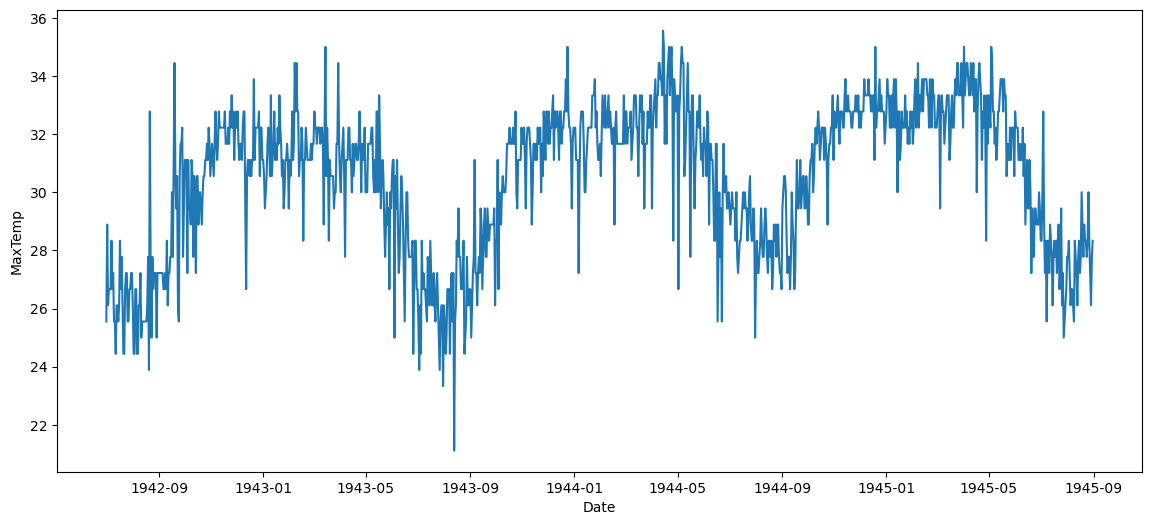

In [140]:
plt.figure(figsize = (14, 6))
sns.lineplot(x = df10001['Date'], y = df10001['MaxTemp'])

It looks like there is some seasonality, reaching the highest temperatures in the summer of the southern hemisphere, as someone would expect from the temperatures across the years. Now, let's see if there is stationarity, using the Augmented Dickey-Fuller (ADF) test.

In [141]:
def stationarity(series):
    result = adfuller(series)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])

stationarity(df10001['MaxTemp'])

ADF Statistic: -2.5126785241069625
p-value: 0.11241989968203031


The p-value is greater than 0.05, so we fail to reject the null hypothesis, which means the temperatures are non-stationary. In other words, it has some time-dependent structure and no constant variance over time. Let's make it stationary by subtracting the previous temperature measure.

In [142]:
#Set the date to index
df10001 = df10001.set_index('Date')

df_diff = df10001.diff().dropna()

stationarity(df_diff)

ADF Statistic: -16.94181429668942
p-value: 9.604814254812098e-30


Now the series is clearly stationary! Let's see how it looks with a seasonal decompose.

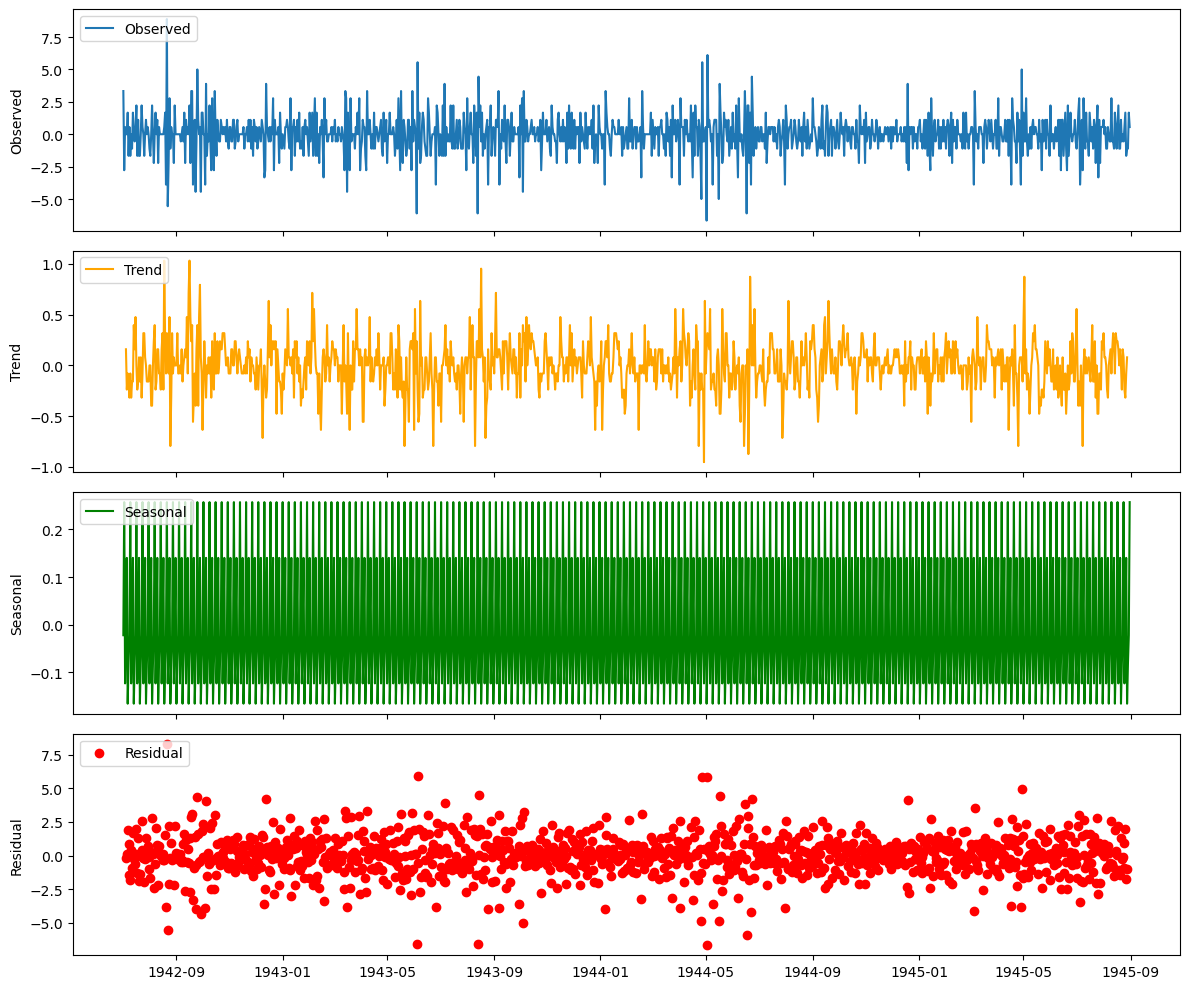

In [127]:

decompose = seasonal_decompose(df_diff.asfreq('D').ffill(), model="additive")

fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True) 

axes[0].plot(decompose.observed, label='Observed')
axes[0].set_ylabel('Observed')
axes[0].legend(loc='upper left')

axes[1].plot(decompose.trend, label='Trend', color='orange')
axes[1].set_ylabel('Trend')
axes[1].legend(loc='upper left')

axes[2].plot(decompose.seasonal, label='Seasonal', color='green')
axes[2].set_ylabel('Seasonal')
axes[2].legend(loc='upper left')

axes[3].scatter(decompose.resid.index, decompose.resid, label='Residual', color='red')
axes[3].set_ylabel('Residual')
axes[3].legend(loc='upper left')

plt.tight_layout()
plt.show()


From the charts above, we can see that the series looks stationary, with no trend and no seasonality (or really subtle). Let's plot the autocorrelation and parcial autocorrelation of this series.

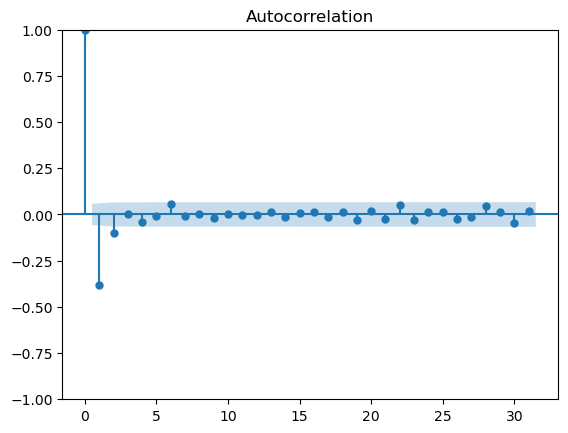

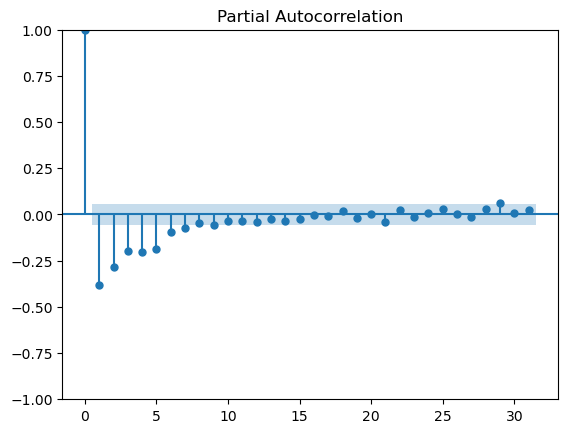

In [128]:
plot_acf(df_diff) #For Moving Average
plot_pacf(df_diff) #For Auto Regressive
plt.show()

From the autocorrelation plot we can see that the first lag is the most correlated (negatively), whereas in the partial autocorrelation plot the first 5 lags are relevant. So an ARMA(5, 1) model should work. Let's try a few combinations of these 2 parameters.

In [167]:
def prediction(data, model_order):

    # Define number of splits
    n_splits = 5
    tscv = TimeSeriesSplit(n_splits = n_splits)


    # Initialize lists to store evaluation metrics
    mae_scores = []
    mae_scores_test = []

    # Iterate over train-test splits and train models
    for train_index, test_index in tscv.split(data):
        train_data, test_data = data.iloc[train_index], data.iloc[test_index]

        # Fit ARIMA model
        model = ARIMA(train_data, order = model_order) 
        fitted_model = model.fit()

        # Make predictions
        predictions_train = fitted_model.forecast(steps = len(train_data))
        predictions = fitted_model.forecast(steps = len(test_data))

        # Calculate Mean Absolute Error
        
        mae = mean_absolute_error(train_data, predictions_train)
        mae_scores.append(mae)
        
        mae_test = mean_absolute_error(test_data, predictions)
        mae_scores_test.append(mae_test)


    results = pd.DataFrame({'MAE train': [np.mean(mae_scores)], 'MAE test': [np.mean(mae_scores_test)]})
    
    return results



In [204]:
orders = [(5, 0, 1), (4, 0, 2), (3, 0, 3), (2, 0, 1), (1, 0, 5), (1, 0, 1), (2, 0, 2), (3, 0, 3), (7, 0, 0)]

for order in orders:
    res = prediction(df10001, order)
    print(F'Results for AR = {order[0]} and MA = {order[2]} \n', res)
    print('')


Results for AR = 5 and MA = 1 
    MAE train  MAE test
0   2.393712  2.172512

Results for AR = 4 and MA = 2 
    MAE train  MAE test
0   2.434261  2.231262

Results for AR = 3 and MA = 3 
    MAE train  MAE test
0    2.42397  2.199368

Results for AR = 2 and MA = 1 
    MAE train  MAE test
0   2.438833  2.237746

Results for AR = 1 and MA = 5 
    MAE train  MAE test
0   2.411351  2.195446

Results for AR = 1 and MA = 1 
    MAE train  MAE test
0   2.395635  2.165575

Results for AR = 2 and MA = 2 
    MAE train  MAE test
0   2.435466  2.232671

Results for AR = 3 and MA = 3 
    MAE train  MAE test
0    2.42397  2.199368

Results for AR = 7 and MA = 0 
    MAE train  MAE test
0   2.319975  2.041787



From the results above, the best one happens with an Auto Regressive model only, with p = 7, obtaining a MAE of 2.04 Celsius degrees. Looking at the autocorrelation and parcial autocorrelation plots that was a possibility. Let's see how it performs on station 10002. 

In [203]:
df_station = df[df['STA'] == 10002][['Date', 'MaxTemp']]

df_station = df_station.set_index('Date')

prediction(df_station, (7, 0, 0))


,MAE train,MAE test
0,1.636123,1.928192


We can see that for station 10002 it has a lower test MAE than station 10001, but the train MAE is greater, so there must be some overfitting. So the model must be adapted to each separate case (station). Let's see what happens when we run the model across all stations and take the average MAE.

In [199]:
mae_train = []
mae_test = []

for station in df['STA'].unique():
    
    df_station = df[df['STA'] == station][['Date', 'MaxTemp']]

    df_station = df_station.set_index('Date')

    results = prediction(df_station, (7, 0, 0))
    
    mae_train.append(results['MAE train'][0])
    mae_test.append(results['MAE test'][0])

In [201]:
print(F'Average training MAE over all stations: {sum(mae_train)/len(mae_train)}')
print(F'Average test MAE over all stations: {sum(mae_test)/len(mae_test)}')

Average training MAE over all stations: 3.810547192650422
Average test MAE over all stations: 3.652441483601618


Now we have an average MAE of 3.65 Celsius degrees. It's clear that the model needs tuning for each station, but at least I did it for one.